# Maximal Quantum Violations for the $I_{3322}$ Bell Inequality


Consider the bipartite non-signaling scenario where Alice and Bob each have three classical inputs and two classical outputs.
The Bell inequalities bounding this scenario are computed in full by [I. Pitowsky and K. Svozil](https://journals.aps.org/pra/).
It was later shown by [D. Collins and N. Gisin](https://iopscience.iop.org/article/10.1088/0305-4470/37/5/021/meta?casa_token=RZb3nMLhJIUAAAAA:gF2JkOypzzEwTxiTiC19UN3lBPUiq2MW0KB47JcD7LNh4GyoF2-dTE1YyB7qu9SWkg5sO1AoyfM) that there is one novel Bell inequality for this scenario, the $I_{3322}$ inequality.
For inputs $x,y\in \{0,1,2\}$ and outputs $a,b\in \{0,1\}$, the $I_{3322}$ Bell inequality is expressed as

\begin{align}
    I_{3322} := &-P_A(0|0) -2P_B(0|0) - P_B(0|1) + P(00|00) +P(00|01) + P(00|02) \\
    &+ P(00|10) + P(00|11) - p(00|12) + P(00|20) - P(00|21) 
\end{align}

The classical upper bound is $I_{3322} \leq \beta_C = 0$.
An interesting feature of this inequality is that the amount of quantum violation increases with larger entanglement Hilbert space dimensions.
Bounds for the infinite dimensional quantum case were produced by [K. Pal and T. Vertesi](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.82.022116) and found to be $I_{3322}\leq \beta_Q \leq 0.250\: 875\: 38$.

In [116]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from context import QNetOptimizer as QNopt

## Qubit Case

The maximal violation is found to be 0.25 for local measurements on single qubits.

In [105]:
num_qubits = 2

prepare_nodes = [QNopt.PrepareNode(1,range(num_qubits),qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits)-1)]
measure_nodes = [
    QNopt.MeasureNode(3,2, [0], qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits//2) - 1),
    QNopt.MeasureNode(3,2, [1], qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits//2) - 1)
]

qubit_ansatz = QNopt.NetworkAnsatz(prepare_nodes, measure_nodes)

In [106]:
def _I_3322_qnode(network_ansatz):
    
    @qml.qnode(network_ansatz.dev)
    def circuit(prepare_settings, measure_settings):
        network_ansatz.fn(prepare_settings, measure_settings)
        
        return qml.probs(wires=network_ansatz.dev.wires)
    
    return circuit

def _I_3322_cost(network_ansatz):
    
    I_3322_qnode = _I_3322_qnode(network_ansatz)
    
    def cost(scenario_settings):
        θ = network_ansatz.layer_settings(scenario_settings[0], [0])
        score = 0

        # P(00|xy) contributions
        a, b = 0, 0
        for (x, y, mult) in [(0,0,1),(0,1,1),(0,2,1),(1,0,1),(1,1,1),(1,2,-1),(2,0,1),(2,1,-1)]:
            ϕ = network_ansatz.layer_settings(scenario_settings[1], [x, y])

            probs_xy = np.reshape(I_3322_qnode(θ, ϕ), (2,2))       
            score += mult * probs_xy[a,b]

        ϕ_00 = network_ansatz.layer_settings(scenario_settings[1], [0,0])
        
        # TODO: Post-process probability vector from `I_3322_qnode(θ, ϕ_00)` to handle multi-qubit case
        probs_00 = np.reshape(I_3322_qnode(θ, ϕ_00), (2,2))

        # - P_A(0|0)
        score += -1 * sum([probs_00[0,b] for b in [0,1]])

        # - 2 * P_B(0|0)
        score += -2 * sum([probs_00[a,0] for a in [0,1]])

        ϕ_11 = network_ansatz.layer_settings(scenario_settings[1],[1,1])
        probs_11 = np.reshape(I_3322_qnode(θ, ϕ_11), (2,2))

        # - P_B(0|1)
        score += -1 * sum([probs_11[a,0] for a in [0,1]])

        return -(score)    

    return cost

In [113]:
# perform gradient descent
init_settings = qubit_ansatz.rand_scenario_settings()
I_3322_cost = _I_3322_cost(qubit_ansatz) 

opt_dict = QNopt.gradient_descent(I_3322_cost, init_settings, step_size = 0.1, num_steps=300)

iteration :  0 , score :  -1.0571140402195285
settings :
 [[tensor([[-3.04232323, -1.69967223, -1.33835846,  2.64927581, -1.73579073,
         -0.52221601,  0.69334777, -2.19045486, -0.07675919, -3.04723922,
          3.11785055,  1.25669234, -0.3054529 , -0.69086197,  2.59283548]], requires_grad=True)], [tensor([[-1.5354718 ,  1.159985  ,  2.58657573],
        [-2.00177547,  0.7648334 , -0.22190964],
        [-0.31568755, -1.98893445,  1.21877283]], requires_grad=True), tensor([[ 0.59967991,  1.59909164,  0.77373312],
        [ 0.97530575, -2.56581975,  2.37083171],
        [-0.98493216,  0.64322839, -0.22004505]], requires_grad=True)]] 

iteration :  25 , score :  -0.055053408082286426
settings :
 [[array([[-3.32846488, -1.36878738, -1.62621696,  2.64689366, -2.00006738,
        -0.58845034,  0.41046035, -2.10539893, -0.61442736, -3.33774857,
         2.94200717,  1.02978354,  0.18719854, -0.50760022,  2.2791725 ]])], [array([[-1.47129732,  1.54701346,  2.58657573],
       [-1.801099

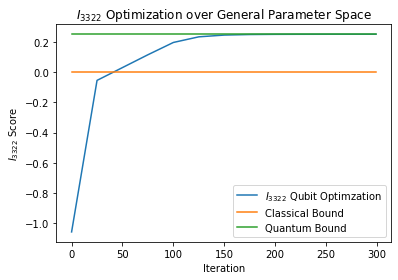

In [120]:
# Plot the score of the Bell throughout the optimization inequality
plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"$I_{3322}$ Qubit Optimzation")
plt.plot(opt_dict["samples"], [0]*len(opt_dict["samples"]), label = "Classical Bound")
plt.plot(opt_dict["samples"], [0.25]*len(opt_dict["samples"]), label = "Quantum Bound")
plt.title(r"$I_{3322}$ Optimization over General Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

## Two-Qubit Case

In [109]:
num_qubits = 4

prepare_nodes = [QNopt.PrepareNode(1,range(num_qubits),qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits)-1)]
measure_nodes = [
    QNopt.MeasureNode(3,2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits//2) - 1),
    QNopt.MeasureNode(3,2, [2,3], qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits//2) - 1)
]

qubit_ansatz2 = QNopt.NetworkAnsatz(prepare_nodes, measure_nodes)

In [111]:

init_settings = qubit_ansatz2.rand_scenario_settings()
I_3322_cost2 = _I_3322_cost(qubit_ansatz2) 

QNopt.gradient_descent(I_3322_cost2, init_settings, step_size = 0.1, num_steps=300)

ValueError: Weights tensor must be of shape (3,); got (15,).

In [42]:
scenario_settings = ansatz.rand_scenario_settings()

In [45]:
I_3322_cost(scenario_settings)

tensor(1.28145876, requires_grad=True)

In [44]:
scenario_settings[0][0][0]


tensor([-0.54631776, -0.81855714,  1.16031831, -1.44966089, -0.28628307,
        -2.49008104,  0.26075946,  2.1370557 , -2.85585357, -0.94767687,
        -0.74345663,  2.22034367, -0.54111641,  0.65043168,  1.45645556], requires_grad=True)

In [12]:
ansatz.layer_settings(scenario_settings[1], [0,0])

[tensor([0., 0., 0.], requires_grad=True),
 tensor([0., 0., 0.], requires_grad=True)]

In [13]:
 for (x, y, mult) in [(0,0, 1),(1,0,-1)]:
        
        print(x, y, mult)
    

0 0 1
1 0 -1


In [30]:
sum([x + 2 for x in range(2)])

5

In [58]:
ansatz.dev.wires

<Wires = [0, 1]>

In [70]:
def RY_circ(settings, wires):
    qml.RY(settings[0],wires = wires)

In [75]:
p_nodes = [
    QNopt.PrepareNode(1,[0],RY_circ,1),
    QNopt.PrepareNode(1,[1],RY_circ,1),
]

m_nodes = [
    QNopt.MeasureNode(2,2,[0], RY_circ,1),
    QNopt.MeasureNode(2,2,[1], RY_circ,1),
]

n_ansatz = QNopt.NetworkAnsatz(p_nodes,m_nodes)

@qml.qnode(n_ansatz.dev)
def n_qnode(prep_settings, meas_settings):
    n_ansatz.fn(prep_settings, meas_settings)
    
    return qml.probs(wires=n_ansatz.dev.wires)


In [87]:
settings = n_ansatz.zero_scenario_settings()
settings[0][0][0] = np.pi
θ = n_ansatz.layer_settings(settings[0],[0,0])

ϕ = n_ansatz.layer_settings(settings[1],[0,0])

probs = n_qnode(θ,ϕ)



In [89]:
np.reshape(probs, (2,2))

tensor([[3.74939946e-33, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00]], requires_grad=True)

In [114]:
opt_dict

{'opt_score': tensor(0.24999055, requires_grad=True),
 'opt_settings': [[array([[-3.14324629, -1.34771451, -1.45206593,  2.35087561, -2.16306964,
           -0.81020995,  0.40171215, -2.27039991, -0.71564583, -3.18848397,
            2.68763468,  1.38986846,  0.30709773, -0.7838134 ,  2.10628412]])],
  [array([[-1.35326738,  1.44120099,  2.58657573],
          [-1.69825883,  0.40472808, -0.22190964],
          [-0.42152118, -0.25471903,  1.21877283]]),
   array([[ 0.38142352,  2.53459345,  0.77373312],
          [ 0.81468242, -2.78658966,  2.37083171],
          [-0.94930694,  0.04657781, -0.22004505]])]],
 'scores': [tensor(-1.05711404, requires_grad=True),
  tensor(-0.05505341, requires_grad=True),
  tensor(0.02964356, requires_grad=True),
  tensor(0.11444717, requires_grad=True),
  tensor(0.1956957, requires_grad=True),
  tensor(0.23291225, requires_grad=True),
  tensor(0.24452773, requires_grad=True),
  tensor(0.24815892, requires_grad=True),
  tensor(0.2493672, requires_grad=True)